# Deepfake Video Detection

## <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Preliminary data exploration</a>  
    * Load the packages  
    * Load the data  
    * Check files type  
- <a href='#5'>Face detection</a>  
- <a href='#6'>Resources</a> 
- <a href='#7'>References</a>     


# <a id='2'>Introduction</a>

**Deepfake**, derived from "Deep Learning" and "Fake," refers to the technology of taking one person's likeness from an image or video  
and replacing it with another's using Deep Artificial Neural Networks. Major companies invest heavily in combating DeepFakes to counter  
this threat. DeepFake is rapidly invading the film industry and threatens to compromise news agencies. Large digital companies, including  
content providers and social platforms, are at the forefront of fighting DeepFakes. GANs (Generative Adversarial Networks) that generate  
DeepFakes are improving daily. 

In the **Data Exploration** section, we perform a partial Exploratory Data Analysis (EDA) on the training and testing data. After checking  
the file types, we focus first on the **metadata** files, exploring them in detail after importing them into dataframes. We then explore  
video files by examining a sample of fake videos followed by real videos. Additionally, we analyze a few videos with the same origin, visualizing  
one frame from both real and fake videos and playing a few videos. 

Next, we perform face (and other objects from the persons in the videos) extraction using OpenCV Haar Cascade resources to identify frontal faces,  
eyes, smiles, and profile faces from still images in the videos.

In the **Resources** section, There is a short list of various resources for GAN and DeepFake, including blog  
posts, Kaggle Kernels, and GitHub repositories.

## <a id='2'>Preliminary data exploration</a>

### Datasets:
There are 4 groups of datasets associated with this competition.

1. **Training Set: This dataset containing labels for the target.**  
2. **Public Validation Set:** We trained our data using a small set of 400 videos/ids contained within this Public Validation Set.  
This is available on the Kaggle Data page as test_videos.zip  
3. **Public Test Set:**   
Our code is running this on Public Test Set. When the re-run is complete, the score will be displayed.  
4. **Private Test Set:**
This dataset is privately held outside of Kaggle’s platform, and is used to compute the private leaderboard. It contains videos  
with a similar format/nature as the Training & Public Validation/Test Sets, but are real, organic videos with and without deepfakes.  

### Workflow:
add more about the workflow

### **Evaluation**
$LogLoss = -\frac{1}{n} \sum_{1=1}^{n} \left[ y_{i} \log \left( \hat{y}_{i} \right) + \left(1 - y_{i}\right) \log \left(1 - \hat{y}_{i} \right) \right] \ $

where

* $n$ is the number of videos being predicted
* $\hat{y}_{i}$ is the predicted probability of the video being FAKE
* $y_{i}$ is 1 if the video is FAKE, 0 if REAL
* $\log( )$ is the natural (base e) logarithm = $\ln(  )$

A smaller log loss is better. The use of the logarithm provides extreme punishments for being both confident and wrong.  
In the worst possible case, a prediction that something is true when it is actually false will add infinite to your error score.  
In order to prevent this, predictions are bounded away from the extremes by a small value.

### Load packages

In [31]:
import numpy as np 
import pandas as pd 
import os
import sys
import matplotlib 
import seaborn as sns  
import matplotlib.pyplot as plt 
from typing import Optional
import torch 
from torch.utils.data import DataLoader 
from tqdm.auto import tqdm 
import cv2 as cv 
import platform
import subprocess
import pyopencl as cl 
import tensorflow as tf 
import getpass
import json
from rocm.configure import * 
from utils.video_dataset import *
from IPython.display import HTML 
from base64 import b64encode
from torchsummary import summary 

In [3]:
print("TensorFlow version:", tf.__version__)
print(sys.version)
print(f'Kernel mode driver status: {subprocess.run("dkms status", shell=True, capture_output=True, text=True).stdout}' )

TensorFlow version: 2.10.1
3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:38:46) [MSC v.1929 64 bit (AMD64)]
Kernel mode driver status: 


### Constants

In [4]:
# DATASET
DATA_CONFIG = './configs/data_path.json'

with open(DATA_CONFIG, 'r') as f:
    data = json.load(f)

ROOT_FOLDER = data['dataset'][getpass.getuser()]["root"]
DATA_FOLDER = data['dataset'][getpass.getuser()]["train_set"]
DATA_SAMPLE_FOLDER = data['dataset'][getpass.getuser()]["data_sample"]
COMPRESSED_DATA_FOLDER = data['dataset'][getpass.getuser()]["compressed"]
TRAIN_SAMPLE_FOLDER = data['dataset'][getpass.getuser()]["train_sample"]
TEST_SAMPLE_FOLDER = data['dataset'][getpass.getuser()]["test_videos"]

BATCH_SIZE = data['batch_size']
DATA_DIRECTORIES = os.listdir(DATA_FOLDER)

# LIBS
FACE_DETECTION_FOLDER = 'input/haar-cascades-for-face-detection'
RUN_OFFLINE = True

### Utility Functions

In [5]:
# UTILITY FUNCTIONS

# Function to display video
def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join(DATA_SAMPLE_FOLDER, subset,video_file),'rb').read()
    data_url = f"data:video/mp4;base64,{b64encode(video_url).decode()}"
    return HTML(f"""<video width=500 controls><source src="{data_url}" type="video/mp4"></video>""")

# Function to display image from a video
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    ax.imshow(frame)
# Function to get the OpenCL platform information
def get_platform_info():
    platforms = cl.get_platforms()
    for platform in platforms:
        devices = platform.get_devices()
        print(f"Platform Name: {platform.get_info(cl.platform_info.NAME)}")
        print(f"Platform Vendor: {platform.get_info(cl.platform_info.VENDOR)}")
        print(f"Platform Version: {platform.get_info(cl.platform_info.VERSION)}")
        print(f"Platform Profile: {platform.get_info(cl.platform_info.PROFILE)}")
        for device in devices:
            print(f"Device: {device.name}")

    amd_platform = next(
        (platform for platform in platforms if 'AMD' in platform.name), None
    )

# Function to check unique values in a dataset
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

# Function to check missing data in a dataset
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

# Function to check the most frequent values in a dataset
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequency'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

# Function to plot the count of classes in a dataset
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes / feature
    param: feature - the feature to analyze
    param: title - title to add to the graph
    param: df - dataframe from which we plot feature's classes distribution 
    param: size - default 1.
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index[:20], palette='Set3', hue=feature, legend=False)
    g.set_title(f"Histogram of {title}")
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center")
    plt.show()

# Function read video metadata from json files
def read_meta_from_json(data_directories, data_folder, compressed_data_folder):
    
    meta_df = pd.DataFrame()

    for index, part_folder in enumerate(data_directories):
        part_path = os.path.join(data_folder, part_folder)
        json_file = next(file for file in os.listdir(part_path) if file.endswith('json'))
        json_file_path = os.path.join(part_path, json_file)
        
        part_df = pd.read_json(json_file_path).T
        part_df['part'] = index
        part_df['path'] = part_path
        part_df['path-compressed'] =  os.path.join(compressed_data_folder, os.path.basename(part_path))
        part_df['filename'] = part_df.index
        
        meta_df = pd.concat([meta_df, part_df])

    # Display 5 random rows from meta_df
    display(meta_df.sample(n=5))
    return meta_df

# Function to display image from a video
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[:6]):
        video_path = os.path.join(DATA_SAMPLE_FOLDER, video_folder,video_file)
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')
        

### Add configurations for AMD GPU - Ubuntu only
1. ADD rocm binary paths to the PATH environment variable.
2. ADD open CL to LD_LIBRARY_PATH
3. ADD user to "render" and "video" groups
4. INSTALL clinfo
5. INSTALL ocl-icd
6. USE rocm-smi to check GPU's performance

In [6]:
if platform.system() == 'Linux' and 'Ubuntu' in platform.version():
    add_rocm_to_path()
    add_ld_library_path()
    check_user_in_groups()
    install_clinfo()
    install_ocl_icd()
    rocm_smi()
    clinfo()
    rocminfo()

### Find physical devices (CPU and GPU)

check that the cpu and gpu are recognized by tensorflow

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


### Limit GPU resource to enable resources for casual work

TensorFlow allocates all of the GPU’s memory by default, leaving nothing for the desktop environment and any  
other apps to use. In order to solve this issue, we save some resources aside for casual workload and maintenance resources.

In [8]:
if gpus := tf.config.experimental.list_physical_devices('GPU'):
  try:
    get_platform_info()
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)


Platform Name: AMD Accelerated Parallel Processing
Platform Vendor: Advanced Micro Devices, Inc.
Platform Version: OpenCL 2.1 AMD-APP (3592.0)
Platform Profile: FULL_PROFILE
Device: gfx1100


### Load data

In [9]:
print(DATA_FOLDER)
train_samples = os.listdir(os.path.join(DATA_SAMPLE_FOLDER, TRAIN_SAMPLE_FOLDER))
test_samples = os.listdir(os.path.join(DATA_SAMPLE_FOLDER, TEST_SAMPLE_FOLDER))

print(f"Train samples: {len(train_samples)}")
print(f"Test samples: {len(test_samples)}")

F:\datasets\deepfake\train_set
Train samples: 401
Test samples: 400


We also added a face detection resource.

In [10]:
print(f"Face detection resources: {os.listdir(FACE_DETECTION_FOLDER)}")

Face detection resources: ['haarcascade_eye.xml', 'haarcascade_eye_tree_eyeglasses.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt_tree.xml', 'haarcascade_frontalface_default.xml', 'haarcascade_fullbody.xml', 'haarcascade_profileface.xml', 'haarcascade_smile.xml', 'haarcascade_upperbody.xml']


## <a id='5'>Face detection</a>  

From [5] ([Face Detection using OpenCV](https://www.kaggle.com/serkanpeldek/face-detection-with-opencv)) by [@serkanpeldek](https://www.kaggle.com/serkanpeldek) we got and slightly modified the functions to extract face, profile face, eyes and smile.  

The class ObjectDetector initialize the cascade classifier (using the imported resource). The function **detect** uses a method of the CascadeClassifier to detect objects into images - in this case the face, eye, smile or profile face.

In [11]:
class ObjectDetector():
    '''
    Class for Object Detection
    '''
    
    def __init__(self,object_cascade_path):
        '''
        param: object_cascade_path - path for the *.xml defining the parameters for {face, eye, smile, profile}
        detection algorithm
        source of the haarcascade resource is: https://github.com/opencv/opencv/tree/master/data/haarcascades
        '''

        self.objectCascade=cv.CascadeClassifier(object_cascade_path)


    def detect(self, image, scale_factor=1.3, min_neighbors=5, min_size=(20,20)):
        '''
        Function return rectangle coordinates of object for given image
        param: image - image to process
        param: scale_factor - scale factor used for object detection
        param: min_neighbors - minimum number of parameters considered during object detection
        param: min_size - minimum size of bounding box for object detected
        '''
        return self.objectCascade.detectMultiScale(
            image,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=min_size,
        )

We load the resources for frontal face, eye, smile and profile face detection.  

Then we initialize the `ObjectDetector` objects defined above with the respective resources, to use CascadeClassifier for each specific task.

In [12]:
# Frontal face, profile, eye and smile  haar cascade loaded
frontal_path = f"{FACE_DETECTION_FOLDER}/haarcascade_frontalface_default.xml"
eye_path = f"{FACE_DETECTION_FOLDER}/haarcascade_eye.xml"
profile_path = f"{FACE_DETECTION_FOLDER}/haarcascade_profileface.xml"
smile_path = f"{FACE_DETECTION_FOLDER}/haarcascade_smile.xml"
paths_list = [frontal_path, eye_path, profile_path, smile_path]

# Detector object created
front_d, eye_d, prof_d, smile_d = [ObjectDetector(path) for path in paths_list]


We also define a function for detection and display of all these specific objects.  

The function call the **detect** method of the **ObjectDetector** object. For each object we are using a different shape and color, as following:
* Frontal face: green rectangle;  
* Eye: red circle;  
* Smile: red rectangle;  
* Profile face: blue rectangle.  

Note: due to a huge amount of false positive, we deactivate for now the smile detector.

In [13]:
def detect_objects(image, scale_factor, min_neighbors, min_size):
    '''
    Objects detection function
    Identify frontal face, eyes, smile and profile face and display the detected objects over the image
    param: image - the image extracted from the video
    param: scale_factor - scale factor parameter for `detect` function of ObjectDetector object
    param: min_neighbors - min neighbors parameter for `detect` function of ObjectDetector object
    param: min_size - minimum size parameter for f`detect` function of ObjectDetector object
    '''
    
    image_gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)


    eyes=eye_d.detect(image_gray,
        scale_factor=scale_factor,
        min_neighbors=min_neighbors,
        min_size=(int(min_size[0]/2), int(min_size[1]/2)))

    for x, y, w, h in eyes:
        #detected eyes shown in color image
        cv.circle(image,(int(x+w/2),int(y+h/2)),(int((w + h)/4)),(0, 0,255),3)
 
    # deactivated due to many false positive
    #smiles=smile_d.detect(image_gray,
    #               scale_factor=scale_factor,
    #               min_neighbors=min_neighbors,
    #               min_size=(int(min_size[0]/2), int(min_size[1]/2)))

    #for x, y, w, h in smiles:
    #    #detected smiles shown in color image
    #    cv.rectangle(image,(x,y),(x+w, y+h),(0, 0,255),3)


    profiles=prof_d.detect(image_gray,
        scale_factor=scale_factor,
        min_neighbors=min_neighbors,
        min_size=min_size)

    for x, y, w, h in profiles:
        #detected profiles shown in color image
        cv.rectangle(image,(x,y),(x+w, y+h),(255, 0,0),3)

    faces=front_d.detect(image_gray,
        scale_factor=scale_factor,
        min_neighbors=min_neighbors,
        min_size=min_size)

    for x, y, w, h in faces:
        #detected faces shown in color image
        cv.rectangle(image,(x,y),(x+w, y+h),(0, 255,0),3)

    # image
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    ax.imshow(image)

The following function extracts an image from a video and then call the function that extracts the face rectangle from the image and display the rectangle above the image.

In [14]:
def extract_image_objects(video_file, video_set_folder=TRAIN_SAMPLE_FOLDER):
    '''
    Extract one image from the video and perform object detection (face, eyes, smile, profile).
    '''
    video_path = os.path.join(video_set_folder, video_file)

    if not os.path.exists(video_path):
        print(f"❌ File not found: {video_path}")
        return

    capture_image = cv.VideoCapture(video_path)
    ret, frame = capture_image.read()

    if not ret or frame is None:
        print(f"⚠️ Failed to read frame from video: {video_path}")
        capture_image.release()
        return

    # Optional: convert to RGB if needed later
    # frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    detect_objects(image=frame, scale_factor=1.3, min_neighbors=5, min_size=(50, 50))
    capture_image.release()

### Read meta data into Pandas' DataFrame

In [15]:
SAVE_PATH = os.path.join(ROOT_FOLDER, 'meta_df.pkl')

if os.path.exists(SAVE_PATH):
    print("📄 Loading existing DataFrame from file...")
    meta_df = pd.read_pickle(SAVE_PATH)
else:
    print("🚀 Generating DataFrame from source...")
    meta_df = read_meta_from_json(DATA_DIRECTORIES, DATA_FOLDER, COMPRESSED_DATA_FOLDER)
    meta_df.to_pickle(SAVE_PATH)
    print(f"💾 DataFrame saved to: {SAVE_PATH}")

📄 Loading existing DataFrame from file...


### Total number of videos in the dataset

In [16]:
print(f"Data samples: {len(meta_df)}")

Data samples: 119154


### Full data set exploration

1. Histogram

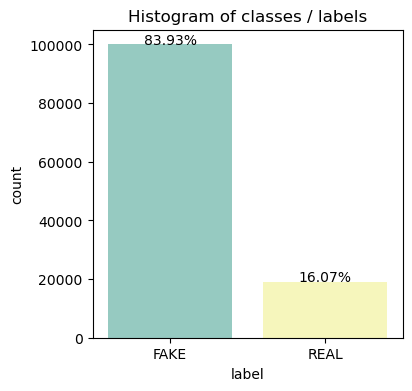

In [17]:
plot_count('label', 'classes / labels', meta_df)

### Use DataLoader to load the videos 

1. **shuffle:** ON
2. **batch size:** 3
3. **source:** DATA_FOLDER
4. **compressed data:** COMPRESSED_DATA_FOLDER

In [18]:
loader = DataLoader(VideoDataset(DATA_FOLDER, 'train'), batch_size=3, shuffle=True)

### Compress the videos into smaller tensor objects for faster processing

In [32]:
import multiprocessing
from multiprocessing import Pool, Manager
from preprocessing.compress_videos import process_chunk

cores = multiprocessing.cpu_count()
print(f"Using {cores} processes.")
print(f"Processing {meta_df.shape[0]} videos. \n{cores} chunks with {meta_df.shape[0] // cores} videos.")

Using 24 processes.
Processing 119154 videos. 
24 chunks with 4964 videos.


In [ ]:
import onnxruntime as ort 
print(ort.get_available_providers())  # Should include 'DirectML'

['DmlExecutionProvider', 'CPUExecutionProvider']
